In [45]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [47]:
import pandas as pd
from pathlib import Path
import pyarrow.parquet as pq

month = 1
year = 2023
path = Path("..") / "data" / "processed" / f"rides_{year}_{month:02}.parquet"

table = pq.read_table(path)
rides = table.to_pandas()
rides.iloc[1000:1020]

,pickup_datetime,pickup_location_id
1000,2023-01-01 00:45:01,231
1001,2023-01-01 00:26:54,238
1002,2023-01-01 00:44:19,43
1003,2023-01-01 00:21:19,239
1004,2023-01-01 00:43:50,151
1005,2023-01-01 00:25:32,132
1006,2023-01-01 00:11:14,237
1007,2023-01-01 00:29:35,163
1008,2023-01-01 00:47:34,114
1009,2023-01-01 00:11:52,141


In [49]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2993140 entries, 0 to 2993139
Data columns (total 2 columns):
 #   Column              Dtype         
---  ------              -----         
 0   pickup_datetime     datetime64[us]
 1   pickup_location_id  int64         
dtypes: datetime64[us](1), int64(1)
memory usage: 45.7 MB


In [51]:
rides["pickup_hour"] = rides["pickup_datetime"].dt.floor('h')
rides.tail()

,pickup_datetime,pickup_location_id,pickup_hour
2993135,2023-01-31 23:58:34,107,2023-01-31 23:00:00
2993136,2023-01-31 23:31:09,112,2023-01-31 23:00:00
2993137,2023-01-31 23:01:05,114,2023-01-31 23:00:00
2993138,2023-01-31 23:40:00,230,2023-01-31 23:00:00
2993139,2023-01-31 23:07:32,262,2023-01-31 23:00:00


In [53]:
agg_rides = rides.groupby(["pickup_hour", "pickup_location_id"]).size().reset_index()
agg_rides.rename(columns={0: "rides"}, inplace=True)
agg_rides.tail()

,pickup_hour,pickup_location_id,rides
69772,2023-01-31 23:00:00,249,137
69773,2023-01-31 23:00:00,256,2
69774,2023-01-31 23:00:00,261,5
69775,2023-01-31 23:00:00,262,11
69776,2023-01-31 23:00:00,263,41


In [55]:
# Original dataset
data = {
    "hour": ["2025-01-28 08:00", "2025-01-28 08:00", "2025-01-28 09:00", "2025-01-28 10:00"],
    "location_id": [1, 2, 1, 2],
    "rides": [10, 5, 8, 12]
}
df = pd.DataFrame(data)
df["hour"] = pd.to_datetime(df["hour"])

df

,hour,location_id,rides
0,2025-01-28 08:00:00,1,10
1,2025-01-28 08:00:00,2,5
2,2025-01-28 09:00:00,1,8
3,2025-01-28 10:00:00,2,12


In [57]:
# get all the hours
hour_col = "hour"
full_hours = pd.date_range(
    start=df[hour_col].min(),
    end=df[hour_col].max(),
    freq="h"
)

full_hours

DatetimeIndex(['2025-01-28 08:00:00', '2025-01-28 09:00:00',
               '2025-01-28 10:00:00'],
              dtype='datetime64[ns]', freq='h')

In [59]:
# unique location ids
location_col = "location_id"
all_locations = df[location_col].unique()
all_locations

array([1, 2])

In [61]:
# Create a list to store the complete data
complete_data = []
rides_col = "rides"
# Iterate over all combinations of hours and locations
for hour in full_hours:
    for location in all_locations:
        # Check if the combination exists in the original DataFrame
        subset = df[(df[hour_col] == hour) & (df[location_col] == location)]
        if not subset.empty:
            # If the combination exists, append the row
            complete_data.append(subset.iloc[0].to_dict())
        else:
            # If the combination is missing, append a row with 0 rides
            complete_data.append({hour_col: hour, location_col: location, rides_col: 0})

df_complete = pd.DataFrame(complete_data)
df_complete

,hour,location_id,rides
0,2025-01-28 08:00:00,1,10
1,2025-01-28 08:00:00,2,5
2,2025-01-28 09:00:00,1,8
3,2025-01-28 09:00:00,2,0
4,2025-01-28 10:00:00,1,0
5,2025-01-28 10:00:00,2,12


In [63]:
df_complete.sort_values(["location_id", "hour"])

,hour,location_id,rides
0,2025-01-28 08:00:00,1,10
2,2025-01-28 09:00:00,1,8
4,2025-01-28 10:00:00,1,0
1,2025-01-28 08:00:00,2,5
3,2025-01-28 09:00:00,2,0
5,2025-01-28 10:00:00,2,12


In [65]:
# Create full combinations of hours and locations
full_combinations = pd.DataFrame(
    [(hour, location) for hour in full_hours for location in all_locations],
    columns=["hour", "location_id"]
)

full_combinations

,hour,location_id
0,2025-01-28 08:00:00,1
1,2025-01-28 08:00:00,2
2,2025-01-28 09:00:00,1
3,2025-01-28 09:00:00,2
4,2025-01-28 10:00:00,1
5,2025-01-28 10:00:00,2


In [67]:
df

,hour,location_id,rides
0,2025-01-28 08:00:00,1,10
1,2025-01-28 08:00:00,2,5
2,2025-01-28 09:00:00,1,8
3,2025-01-28 10:00:00,2,12


In [69]:
# Merge with the original dataset
merged_df = pd.merge(full_combinations, df, on=["hour", "location_id"], how="left")
merged_df

,hour,location_id,rides
0,2025-01-28 08:00:00,1,10.0
1,2025-01-28 08:00:00,2,5.0
2,2025-01-28 09:00:00,1,8.0
3,2025-01-28 09:00:00,2,NaN
4,2025-01-28 10:00:00,1,NaN
5,2025-01-28 10:00:00,2,12.0


In [71]:
merged_df["rides"] = merged_df["rides"].fillna(0).astype(int)
merged_df

,hour,location_id,rides
0,2025-01-28 08:00:00,1,10
1,2025-01-28 08:00:00,2,5
2,2025-01-28 09:00:00,1,8
3,2025-01-28 09:00:00,2,0
4,2025-01-28 10:00:00,1,0
5,2025-01-28 10:00:00,2,12


In [73]:
def fill_missing_rides_full_range(df, hour_col, location_col, rides_col):
    """
    Fills in missing rides for all hours in the range and all unique locations.

    Parameters:
    - df: DataFrame with columns [hour_col, location_col, rides_col]
    - hour_col: Name of the column containing hourly timestamps
    - location_col: Name of the column containing location IDs
    - rides_col: Name of the column containing ride counts

    Returns:
    - DataFrame with missing hours and locations filled in with 0 rides
    """
    # Ensure the hour column is in datetime format
    df[hour_col] = pd.to_datetime(df[hour_col])

    # Get the full range of hours (from min to max) with hourly frequency
    full_hours = pd.date_range(
        start=df[hour_col].min(),
        end=df[hour_col].max(),
        freq="h"
    )

    # Get all unique location IDs
    all_locations = df[location_col].unique()

    # Create a DataFrame with all combinations of hours and locations
    full_combinations = pd.DataFrame(
        [(hour, location) for hour in full_hours for location in all_locations],
        columns=[hour_col, location_col]
    )

    # Merge the original DataFrame with the full combinations DataFrame
    merged_df = pd.merge(full_combinations, df, on=[hour_col, location_col], how='left')

    # Fill missing rides with 0
    merged_df[rides_col] = merged_df[rides_col].fillna(0).astype(int)

    return merged_df

In [75]:
agg_rides

,pickup_hour,pickup_location_id,rides
0,2023-01-01 00:00:00,4,19
1,2023-01-01 00:00:00,7,3
2,2023-01-01 00:00:00,12,1
3,2023-01-01 00:00:00,13,14
4,2023-01-01 00:00:00,24,20
...,...,...,...
69772,2023-01-31 23:00:00,249,137
69773,2023-01-31 23:00:00,256,2
69774,2023-01-31 23:00:00,261,5
69775,2023-01-31 23:00:00,262,11


In [77]:
hour_col = "pickup_hour"
location_col = "pickup_location_id"
rides_col = "rides"
agg_data_filled = fill_missing_rides_full_range(agg_rides, hour_col, location_col, rides_col).sort_values(["pickup_location_id", "pickup_hour"]).reset_index(drop=True)

In [79]:
pd.set_option('display.max_rows', 2000)
agg_data_filled.head(1489)


,pickup_hour,pickup_location_id,rides
0,2023-01-01 00:00:00,2,0
1,2023-01-01 01:00:00,2,0
2,2023-01-01 02:00:00,2,0
3,2023-01-01 03:00:00,2,0
4,2023-01-01 04:00:00,2,0
5,2023-01-01 05:00:00,2,0
6,2023-01-01 06:00:00,2,0
7,2023-01-01 07:00:00,2,0
8,2023-01-01 08:00:00,2,0
9,2023-01-01 09:00:00,2,0


In [81]:
from typing import Optional, List
import plotly.express as px
import pandas as pd

def plot_rides(
    rides: pd.DataFrame,
    locations: Optional[List[int]] = None
):

    rides_to_plot = rides[rides.pickup_location_id.isin(locations)] if locations else rides

    fig = px.line(
        rides_to_plot,
        x="pickup_hour",
        y="rides",
        color="pickup_location_id",
        template="none"
    )

    fig.show()

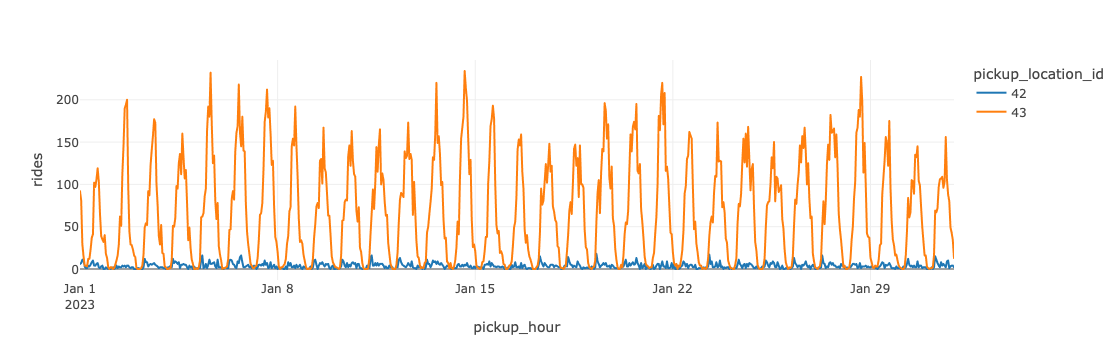

In [83]:
plot_rides(agg_data_filled, locations=[42, 43])

In [85]:
month = 1
year = 2023
path = Path("..") / "data" / "processed" / f"ts_data_{year}_{month:02}.parquet"

agg_data_filled.to_parquet(path)